In [1]:
import re
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
df = pd.read_csv('./t3_train.csv')
df_test = pd.read_csv('./t3_test.csv')
df.drop(['id','keyword','place'],axis=1,inplace=True)
df.head()

,tweet,disaster
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet     7613 non-null   object
 1   disaster  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


In [4]:
df['disaster'].value_counts()

disaster
0    4342
1    3271
Name: count, dtype: int64

In [5]:
#pre processing text
def preprocess_text(text_column):
    # df.drop(['id','keyword','place'],axis=1,inplace=True)
    # Convert text to lowercase
    text_column = text_column.str.lower()

    # Remove punctuations
    text_column = text_column.str.replace('[^\w\s]', '')

    # Remove digits
    text_column = text_column.str.replace('\d+', '')

    # Remove new line and carriage return
    text_column = text_column.str.replace('\n', ' ').replace('\r', ' ')
    # Remove URLs
    text_column = text_column.apply(lambda x: re.sub(r'http\S+', '', x))

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text_column = text_column.apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

    # Initialize Porter Stemmer
    pr = PorterStemmer()

    # Tokenize and stem
    def tokenize_and_stem(text):
        tokens = nltk.word_tokenize(text)
        stemmed_tokens = [pr.stem(token) for token in tokens]
        return ' '.join(stemmed_tokens)

    # Apply tokenization and stemming
    text_column = text_column.apply(tokenize_and_stem)

    return text_column



In [6]:
# Preprocess the 'text' column and store in 'text_processed' column
df['text_processed'] = preprocess_text(df['tweet'])
# df_test['text_processed'] = preprocess_text(df_test['tweet'])

X_data = df['text_processed']
Y_data = df['disaster'].values
Y_data.tolist();

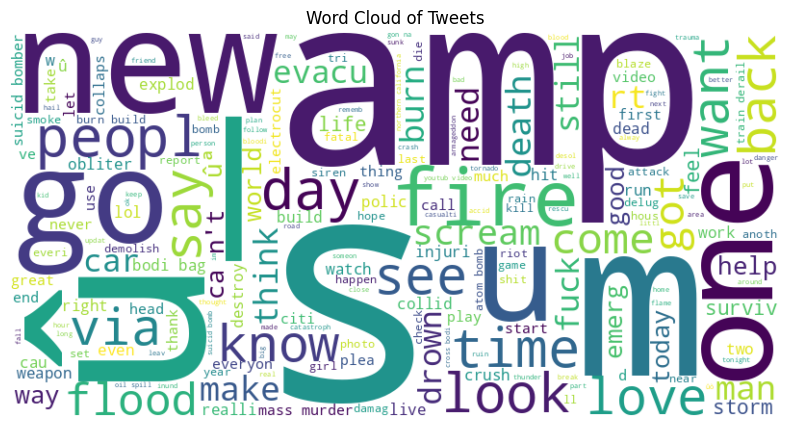

In [7]:
# Concatenate all tweets into a single string
text = ' '.join(df['text_processed'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweets')
plt.show()


In [8]:

def model_classification(x_train, x_test, y_train, y_test):
    models = [
        LogisticRegression(),
        KNeighborsClassifier(n_neighbors=5),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        AdaBoostClassifier(),
        GradientBoostingClassifier(),
        MultinomialNB(),
        BernoulliNB()
    ]
    results = []
    for model in models:
        model.fit(x_train, y_train)
        model_predict = model.predict(x_test)
        results.append(accuracy_score(model_predict, y_test))

    best_model = models[results.index(max(results))]

    models_df = pd.DataFrame({
        'Model': ['LogisticRegression', 'KNeighborsClassifier', 'DecisionTreeClassifier',
                  'RandomForestClassifier', 'AdaBoostClassifier', 'GradientBoostingClassifier',
                  'MultinomialNB', 'BernoulliNB'],
        'Score': results
    })

    print(models_df.sort_values(by='Score', ascending=False, ignore_index=True))

    return best_model



In [9]:

x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)
# x_train, x_test, y_train, y_test = train_test_split(x_vect, Y_data, test_size=0.2, random_state=42)

vectorizer = CountVectorizer(stop_words='english')
X_train_vect = vectorizer.fit_transform(x_train)

# Step 2: Transform the test data using the already fit vectorizer
X_test_vect = vectorizer.transform(x_test)

best_model= model_classification(X_train_vect, X_test_vect, y_train, y_test)


                        Model     Score
0                 BernoulliNB  0.799737
1          LogisticRegression  0.795798
2               MultinomialNB  0.795141
3      RandomForestClassifier  0.782009
4  GradientBoostingClassifier  0.746553
5      DecisionTreeClassifier  0.736704
6          AdaBoostClassifier  0.732108
7        KNeighborsClassifier  0.706500


<Figure size 800x600 with 0 Axes>

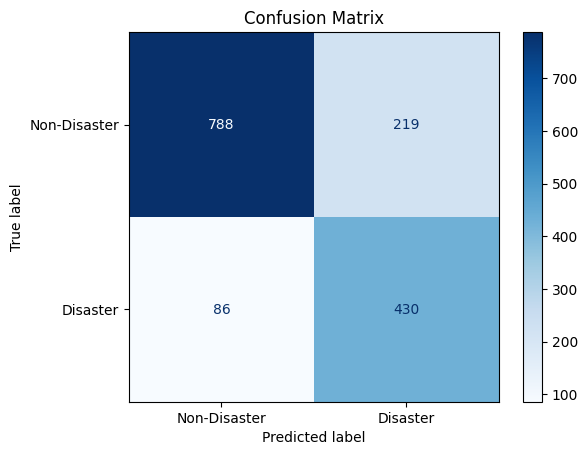

In [10]:
Y_pred = best_model.predict(X_test_vect)

# Compute confusion matrix
cm = confusion_matrix(Y_pred, y_test)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Disaster', 'Disaster'])
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [11]:

# Preprocess the 'text' column and store in 'text_processed' column
df_test['text_processed'] = preprocess_text(df_test['tweet'])

# Now, assign the processed text directly to X_data
X_test_dataset = df_test['text_processed']


In [12]:
x_testvect= vectorizer.transform(X_test_dataset)

predictions = best_model.predict(x_testvect)

# Print the predictions
print(predictions)

[1 0 1 ... 1 1 1]
